## Building the Ship

In [342]:
import random

# d = int(input("Grid size: "))
d = 40

grid = [[0 for _ in range(d+2)] for _ in range(d+2)]
    
# Set the first and last rows to 1s
for j in range(d+2):
    grid[0][j] = 2  # First row
    grid[d+1][j] = 2  # Last row

# Set the first and last columns to 1s
for i in range(d+2):
    grid[i][0] = 2 # First column
    grid[i][d+1] = 2 # Last column
    
for r in grid:
    for c in r:
        print(c, end=" ")
    print()

2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [343]:
def checkNeighbors(grid, r, c, a):
    return [grid[r-1][c],grid[r+1][c],grid[r][c-1],grid[r][c+1]].count(a)

In [344]:

x = random.randint(1, d)
y = random.randint(1, d)


fringe = []
fringe.append((x,y))

deadEnds = []

while len(fringe) > 0:
    curr = random.choice(fringe)
    fringe.remove(curr)
    r, c = curr[0], curr[1]
    if checkNeighbors(grid, r, c, 1) > 1:
        continue
    grid[r][c] = 1
    up = (r-1, c) 
    down = (r+1, c) 
    left = (r, c-1) 
    right = (r, c+1)
    deadEnd = True
    for elt in [up, down, left, right]:
        if grid[elt[0]][elt[1]] == 0:
            numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
            if numOpenNeighbors == 1:
                deadEnd = False
                fringe.append(elt)
    if deadEnd:
        deadEnds.append(curr)
        

count = 0   
for row in grid:
    count += row.count(1)

print(f"Percent of cells opened: {100*count/(d*d)}")

Percent of cells opened: 60.75


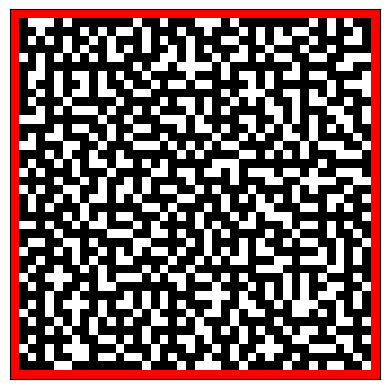

In [345]:
import matplotlib.pyplot as plt
import numpy as np

color_map = {
    0: 'white',
    1: 'black',
    2: 'red'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(grid)):
    for j in range(len(grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(grid[0]))
ax.set_ylim(0, len(grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

black = open cells, red = wall

In [346]:
for elt in deadEnds:
    if grid[elt[0]][elt[1]] == 2:
        deadEnds.remove(elt)
        continue
    numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
    if numOpenNeighbors > 1:
        deadEnds.remove(elt)

newList = random.sample(deadEnds, len(deadEnds) // 2)
for elt in newList:
    r = elt[0]
    c = elt[1]
    up = (r-1, c) 
    down = (r+1, c) 
    left = (r, c-1) 
    right = (r, c+1)
    neighbors = [up,down,left,right]
    for pt in neighbors:
        if grid[pt[0]][pt[1]] == 1 or grid[pt[0]][pt[1]] == 2:
            neighbors.remove(pt)
#     print(neighbors)
    curr = random.choice(neighbors)
    while grid[curr[0]][curr[1]] == 2:
        curr = random.choice(neighbors)
    grid[curr[0]][curr[1]] = 1

count = 0   
for row in grid:
    count += row.count(1)

print(f"Percent of cells opened: {100*count/(d*d)}")

Percent of cells opened: 65.375


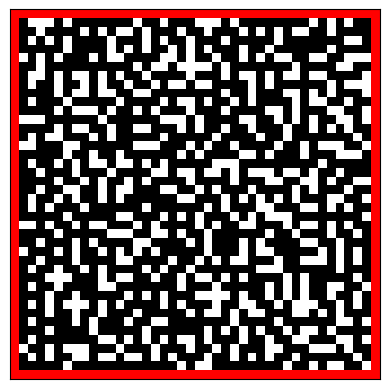

In [347]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(grid)):
    for j in range(len(grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(grid[0]))
ax.set_ylim(0, len(grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

## Coding the Fire


In [348]:
def setFire(grid, pt, q):
    if grid[pt[0]][pt[1]] == 3:
        return
    k = checkNeighbors(grid, pt[0], pt[1], 3)
    prob = 1 - (1-q)**k
    x = random.random()
    if x <= prob:
        grid[pt[0]][pt[1]] = 3
    return

In [349]:
def spreadFire(grid, fireLocs):
    fireLocsNew = []
    for curr in fireLocs:
        setFire(grid, curr, 0.5)
        if grid[curr[0]][curr[1]] == 3:
            fireLocs.remove(curr)
            neighbors = [(curr[0]-1,curr[1]), (curr[0]+1,curr[1]), (curr[0], curr[1]-1), (curr[0], curr[1]+1)]
            for elt in neighbors:
                if grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4:
                    fireLocsNew.append(elt)
    fireLocs.extend(fireLocsNew)
    return fireLocs

## Location Initializations

In [350]:
botLoc = (random.randint(1, d), random.randint(1, d))
while grid[botLoc[0]][botLoc[1]] == 0:
    botLoc = (random.randint(1, d), random.randint(1, d))

butLoc = (random.randint(1, d), random.randint(1, d))
while grid[butLoc[0]][butLoc[1]] == 0:
    butLoc = (random.randint(1, d), random.randint(1, d))

fireLoc = (random.randint(1, d), random.randint(1, d))
while grid[fireLoc[0]][fireLoc[1]] == 0:
    fireLoc = (random.randint(1, d), random.randint(1, d))

notDistinct = (botLoc == butLoc) or (botLoc == fireLoc) or (butLoc == fireLoc)
#print(distinct)

while notDistinct:
    while grid[botLoc[0]][botLoc[1]] == 0:
        botLoc = (random.randint(1, d), random.randint(1, d))
    while grid[butLoc[0]][butLoc[1]] == 0:
        butLoc = (random.randint(1, d), random.randint(1, d))
    while grid[fireLoc[0]][fireLoc[1]] == 0:
        fireLoc = (random.randint(1, d), random.randint(1, d))


print(f"Bot Location: {botLoc}")
print(f"Button Location: {butLoc}")
print(f"Fire Location: {fireLoc}")

Bot Location: (1, 18)
Button Location: (40, 7)
Fire Location: (28, 2)


## Shortest Path (Bot 1)

In [351]:
import copy

bot1Grid = copy.deepcopy(grid)
bot1Grid[fireLoc[0]][fireLoc[1]] = 3

fringe1 = []
fringe1.append(botLoc)

closed_set = {}
prev1 = {}
prev1[botLoc] = None

while len(fringe1) > 0:
    curr1 = fringe1.pop(0)
    if curr1 == butLoc:
        #print(curr1)
        print("Success")
        break
    
    if curr1 not in closed_set:
        closed_set.update({curr1: 1})
        r1, c1 = curr1[0], curr1[1]
        neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
        for elt in neighbors1:
            if bot1Grid[elt[0]][elt[1]] == 1 and elt not in closed_set:
                fringe1.append(elt)
                prev1[elt] = curr1
#print(prev1)

path = []
curr = butLoc
while curr is not None:
    path.append(curr)
    curr = prev1[curr]

# Return the path from start to finish
path = path[::-1]  # Reverse the path to go from start to finish
print(path)

Success
[(1, 18), (2, 18), (2, 17), (2, 16), (3, 16), (4, 16), (5, 16), (5, 15), (5, 14), (5, 13), (6, 13), (6, 12), (6, 11), (7, 11), (8, 11), (8, 12), (9, 12), (9, 13), (10, 13), (11, 13), (11, 12), (12, 12), (13, 12), (14, 12), (15, 12), (15, 11), (15, 10), (15, 9), (15, 8), (16, 8), (17, 8), (18, 8), (18, 9), (19, 9), (20, 9), (21, 9), (22, 9), (23, 9), (23, 8), (24, 8), (25, 8), (26, 8), (27, 8), (27, 9), (28, 9), (29, 9), (30, 9), (31, 9), (32, 9), (33, 9), (34, 9), (34, 8), (35, 8), (36, 8), (37, 8), (37, 9), (38, 9), (39, 9), (40, 9), (40, 8), (40, 7)]


## Game Loop (Bot 1)

In [352]:
t = 1
fireLocs = []
r,c = fireLoc[0], fireLoc[1]
fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
success = True
for i in path:
    fireLocs = spreadFire(bot1Grid, fireLocs)
    if bot1Grid[i[0]][i[1]] == 3:
        print(f"Bot1 failed in {t} timesteps.")
        success = False
        break
    t = t + 1
    bot1Grid[i[0]][i[1]] = 4
l = len(path)
bot1Grid[butLoc[0]][butLoc[1]] = 5
bot1Grid[fireLoc[0]][fireLoc[1]] = 6
if success: print("Success!")

Bot1 failed in 37 timesteps.


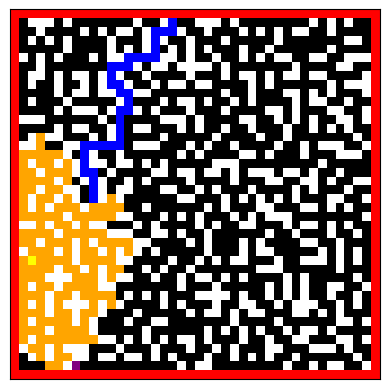

In [353]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(bot1Grid)):
    for j in range(len(bot1Grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[bot1Grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(bot1Grid[0]))
ax.set_ylim(0, len(bot1Grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

The yellow dot represents the source of the fire. The pink dot represents the button.

## Shortest Path (Bot 3)

In [354]:
def shortestBot3(grid, botLoc, fireLocs, butLoc, i, path):
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None
    success = False

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
            success = True
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4) and elt not in closed_set and elt not in fireLocs:
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)
    if not success: 
        return path

    path2 = []
    curr = butLoc
#     print(prev1)
    while curr is not None:
        path2.append(curr)
        curr = prev1[curr]
    path2 = path2[::-1]
    if path2 != path[i:]:
        path[i:] = path2

    # Return the path from start to finish
    return path  # Reverse the path to go from start to finish

## Game Loop (Bot 3)

In [355]:
bot3Grid = copy.deepcopy(grid)
bot3Grid[fireLoc[0]][fireLoc[1]] = 3

t = 1
fireLocs = []
r,c = fireLoc[0], fireLoc[1]
fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
success = True
pathBot3 = []
pathBot3.append(botLoc)
pathBot3 = shortestBot3(bot3Grid, botLoc, fireLocs, butLoc, 0, pathBot3)
i = 0
while i < len(pathBot3):
    fireLocs = spreadFire(bot3Grid, fireLocs)
    if bot3Grid[pathBot3[i][0]][pathBot3[i][1]] == 3:
        print(f"Bot3 failed in {t} timesteps.")
        success = False
        break
    bot3Grid[pathBot3[i][0]][pathBot3[i][1]] = 4
    pathBot3 = shortestBot3(bot3Grid, pathBot3[i], fireLocs, butLoc, i, pathBot3)
    t = t + 1
    i = i + 1
l = len(path)
bot3Grid[butLoc[0]][butLoc[1]] = 5
bot3Grid[fireLoc[0]][fireLoc[1]] = 6
if success: print("Success!")

Bot3 failed in 58 timesteps.


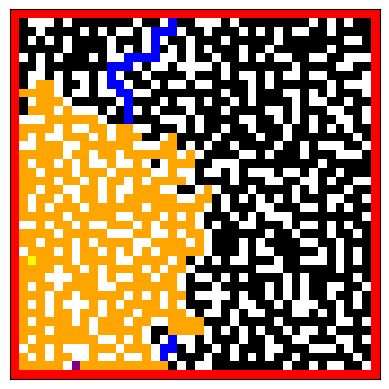

In [356]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(bot3Grid)):
    for j in range(len(bot3Grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[bot3Grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(bot3Grid[0]))
ax.set_ylim(0, len(bot3Grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

## Bot 4 Logic
The expression that represents the probability of a given cell being set on fire is:
$$
1-(1-q)^K
$$
where
$q = \text{ship flammability,}$
$K = \text{number of on-fire neighbors.}$

Our approach for Bot 4 will be an implementation of Dijkstra's Shortest-Path Algorithm in which our cost function will take in a given cell's probability of being set on fire several steps in advance. There are a few ways to perform this:
1. Markov Chain Monte Carlo Method: Before starting the algorithm, simulate the fire spreading throughout the grid many times. Create a dataframe that records each open cell and which timestep it was set on fire, with cells as rows and simulations as columns. We will be able to estimate the likelihood of a given cell being on fire by a given timestep by taking the rate of being on fire out of all simulations. This will give an estimate for the true distribution of probabilities for each cell. Then, when running Dijkstra's, when considering a cell for exploration, we take into account its calculated probability.
2. For each iteration of Dijkstra's, given a cell being considered, mathematically calculate its probability that it will be set on fire by a certain timestep. This is possible but would be more expensive than simulation.

We will choose option 1 with cost function $$C(node)=c*p(node)*d$$ 
where 
$$c=\text{some constant},$$
$$p(node)=\text{probability of a node being on fire by the time the bot reaches it},$$
$$d=\text{Manhattan distance from node to button.}$$

Note that using the Manhattan distance is a relaxation of the problem, as it assumes that every cell between the bot and the button is open.

Also note that the constant $c$ allows us to quantify how risk-averse we want to be. A higher $c$ will punish higher probabilities and higher estimated distances. For now we will set $c=1$.